In [1]:
import numpy as np
import random
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# plt.style.use("ggplot")
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath,bm,mathpazo}"
plt.rcParams["font.family"] = "serif"

# Phase oscillators code
from VanderPol1 import VdP, VdP_for_adjoint
from Phases import Phase_transform

# Fourier coefficient estimate
import Estimator_module
import Adjoint_module

# GP estimate
import tensorflow as tf
tf.config.set_visible_devices([], "GPU")
from tensorflow.python.ops.numpy_ops import np_config; np_config.enable_numpy_behavior()    
import gpflow
from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter
from GPRegression import run_adam, NormalizedPeriodic, run_scipy_minimize

# config

In [2]:
# 名前
folder = "fig20221121"
fname = "exp01case01"

# 系の設定
n_oscillator = 2 # 振動子の数
param_a1, param_a2 = 0.3, 0.7
param_K1, param_K2 = 0.01, 0.01
param_sigma = 0.1


# 推定に使う時系列の長さ
n_cycle = 20
# 何試行行うか
n_trial = 20

# hyper parameter
# 推定に使うハイパーパラメータを指定
alpha_0, beta_0 = 0.1, 0.1
## lambda_0が大きいほど関数の分散は明確に小さくなる. 基本的に0以上を設定
log10_lambda_0_min, log10_lambda_0_max = 1, 1
## 各PRCの次数
M_min, M_max = 0, 10

# ガウス過程回帰の補助変数の数
M = 10
minibatch_size = 500


## SDE time step
dt = 0.01
# t_end = 10000.0

## サンプリング間隔
sample_stride = 20
Dt = dt * sample_stride # Dt = 0.2

# Adjoint法

In [3]:
"""
ode1 = VdP_for_adjoint()
ode1.a = param_a1

init_x0=np.array([0.1, 0.1])
x0_marker1, period1 = ode1.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算
adjoint_omega1 = (2.0*np.pi)/period1

adj_solver1 = Adjoint_module.Adjoint(ode1.F, ode1.J)
adj_solver1.grid = 2**10+1 
X1, tspan1 = adj_solver1.calculate_X(x0_marker1, period1)
adjoint_Z1 = adj_solver1.calculate_Z(X1, tspan1)
adjoint_phi1 = 2.0*np.pi*(tspan1/tspan1[-1])

ode2 = VdP_for_adjoint()
ode2.a = param_a2

init_x0=np.array([0.1, 0.1])
x0_marker2, period2 = ode2.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算
adjoint_omega2 = (2.0*np.pi)/period2

adj_solver2 = Adjoint_module.Adjoint(ode2.F, ode2.J)
adj_solver2.grid = 2**10+1 
X2, tspan2 = adj_solver2.calculate_X(x0_marker2, period2)
adjoint_Z2 = adj_solver2.calculate_Z(X2, tspan2)
adjoint_phi2 = 2.0*np.pi*(tspan2/tspan2[-1])
"""

'\node1 = VdP_for_adjoint()\node1.a = param_a1\n\ninit_x0=np.array([0.1, 0.1])\nx0_marker1, period1 = ode1.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算\nadjoint_omega1 = (2.0*np.pi)/period1\n\nadj_solver1 = Adjoint_module.Adjoint(ode1.F, ode1.J)\nadj_solver1.grid = 2**10+1 \nX1, tspan1 = adj_solver1.calculate_X(x0_marker1, period1)\nadjoint_Z1 = adj_solver1.calculate_Z(X1, tspan1)\nadjoint_phi1 = 2.0*np.pi*(tspan1/tspan1[-1])\n\node2 = VdP_for_adjoint()\node2.a = param_a2\n\ninit_x0=np.array([0.1, 0.1])\nx0_marker2, period2 = ode2.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算\nadjoint_omega2 = (2.0*np.pi)/period2\n\nadj_solver2 = Adjoint_module.Adjoint(ode2.F, ode2.J)\nadj_solver2.grid = 2**10+1 \nX2, tspan2 = adj_solver2.calculate_X(x0_marker2, period2)\nadjoint_Z2 = adj_solver2.calculate_Z(X2, tspan2)\nadjoint_phi2 = 2.0*np.pi*(tspan2/tspan2[-1])\n'

# 結合関数計算

In [4]:
def V_12(x_r, x_s):
    """ x_r:x_1, x_s:x_2
    SDEの結合と整合性があることを確認！"""
    K = param_K1 # param_K1はグローバル
    u_r, v_r = x_r
    u_s, v_s = x_s
    return np.array([K*(u_s-u_r), K*(u_s**2)*v_s])

def V_21(x_r, x_s):
    """ x_r:x_2, x_s:x_1
    SDEの結合と整合性があることを確認！"""
    K = param_K2 # param_K2はグローバル
    u_r, v_r = x_r
    u_s, v_s = x_s
    return np.array([-K*(u_s**2)*v_s, K*u_s*(v_s**2)])
        

# adjoint_Gamma1 = Adjoint_module.Calculater_Gamma(V_12, adjoint_phi1, X1, X2, adjoint_Z1)
# adjoint_Gamma2 = Adjoint_module.Calculater_Gamma(V_21, adjoint_phi2, X2, X1, adjoint_Z2)

# theories = [(adjoint_phi1, adjoint_Gamma1+adjoint_omega1), (adjoint_phi2, adjoint_Gamma2+adjoint_omega2)]
# with open("vdp.pickle", "wb") as f:
#     pickle.dump(theories, f)
with open("vdp.pickle", "rb") as f:
    theories = pickle.load(f)

# SDE計算用の初期値を用意

In [5]:
# ODEの定義
tmp_c = VdP()
tmp_c.a1 = param_a1;  tmp_c.a2 = param_a2
tmp_c.K1 = param_K1;  tmp_c.K2 = param_K2
tmp_c.sigma = 0.0
tmp_tspan = np.arange(0.0, 100, 0.01)
# 解く!!!!!!!!
ans = tmp_c.solve_SDE(np.random.randn(4), tmp_tspan)
# transientを切る
idx_cutoff = 5000
ans_cutoff = ans[idx_cutoff:]; n_ans = ans_cutoff.shape[0]
# randomly select initial value with some noise
n_init = n_trial
idx1_init = random.choices(np.arange(n_ans), k=n_init)
idx2_init = random.choices(np.arange(n_ans), k=n_init)
xs_init = np.hstack([ans_cutoff[idx1_init][:,:2], ans_cutoff[idx2_init][:,2:]])

# SDE計算

In [6]:
c = VdP()
c.a1 = param_a1;  c.a2 = param_a2
c.K1 = param_K1;  c.K2 = param_K2
c.sigma = param_sigma

u1s, v1s, u2s, v2s = [], [], [], []
for x0 in tqdm(xs_init):
    t_max = 6.3184*n_cycle # 一番目の振動子の周期が6.3184...[s]
    tspan = np.arange(0.0, t_max, dt)
    result = c.solve_SDE(x0, tspan)
    # np.save("vdp_yoneda01", result) # データ保存
    # result = np.load("vdp_yoneda01.npy")
    u1, v1 = result[:,0], result[:,1]
    u2, v2 = result[:,2], result[:,3]
    u1s.append(u1)
    v1s.append(v1)
    u2s.append(u2)
    v2s.append(v2)

100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


# 位相作成

In [7]:
Ps = []
for i in range(n_trial):
    u1, v1, u2, v2 = u1s[i], v1s[i], u2s[i], v2s[i]
    # サンプリング
    tspan_stride = tspan[::sample_stride]
    u1_stride, v1_stride = u1[::sample_stride], v1[::sample_stride]
    u2_stride, v2_stride  = u2[::sample_stride], v2[::sample_stride]

    # proto-phase (angle)  # -u+v*1j
    sig1 = -u1_stride+v1_stride*1j; sig2 = -u2_stride+v2_stride*1j
    proto_phase1 = np.angle(sig1 - sig1.mean())
    proto_phase2 = np.angle(sig2 - sig2.mean())

    # 位相を求める
    pt = Phase_transform()
    Sm1 = pt.calculate_Sm(proto_phase1)
    phase1 = np.unwrap(pt.kralemann_phase(proto_phase1, Sm1))
    Sm2 = pt.calculate_Sm(proto_phase2)
    phase2 = np.unwrap(pt.kralemann_phase(proto_phase2, Sm2))
    # 推定用の位相時系列
    P = np.vstack([phase1, phase2]).T
    Ps.append(P)

# Fourier coefficient estimation

In [8]:
v1_mean = (Ps[0][-1,0] - Ps[0][0,0]) / (tspan[-1] - tspan[0])
v2_mean = (Ps[0][-1,1] - Ps[0][0,0]) / (tspan[-1] - tspan[0])
vs_mean = [v1_mean, v2_mean]

# receiver:1
Estimator1 = Estimator_module.Estimator(receiver=0, N=2,
                                        M_min=M_min, M_max=M_max,
                                        log10_lambda_0_min=log10_lambda_0_min, 
                                        log10_lambda_0_max=log10_lambda_0_max,  
                                        alpha_0=alpha_0, beta_0=beta_0)

Estimator1.set_init_all(v1_mean) # set intial condition (initial condition of omega)
for P in tqdm(Ps):
    Estimator1.update_all(P, delta_t=Dt) # update
result_model1, _ = Estimator1.model_selection() # model selection
# receiver:2
Estimator2 = Estimator_module.Estimator(receiver=1, N=2,
                                        M_min=M_min, M_max=M_max,
                                        log10_lambda_0_min=log10_lambda_0_min, 
                                        log10_lambda_0_max=log10_lambda_0_max,  
                                        alpha_0=alpha_0, beta_0=beta_0)
Estimator2.set_init_all(v2_mean) # set intial condition (initial condition of omega)
for P in tqdm(Ps):
    Estimator2.update_all(P, delta_t=Dt) # update
result_model2, _ = Estimator2.model_selection() # model selection

# データ整理
G1m, G1s, phi  = result_model1.return_Gamma(sender=1)
O1m, O1s = result_model1.return_omega()
Gamma1_order = result_model1.return_Gamma_order(sender=1)
G2m, G2s, _   = result_model2.return_Gamma(sender=0)
O2m, O2s = result_model2.return_omega()
Gamma2_order = result_model2.return_Gamma_order(sender=0)
otas = [(phi, G1m+O1m, G1s, Gamma1_order), (phi, G2m+O2m, G2s, Gamma2_order)]

100%|██████████| 20/20 [00:00<00:00, 156.09it/s]


# GP regression estimation

In [9]:
tmp_trains = []
for P in Ps:
    p1, p2 = P[:,0], P[:,1]
    X1, Y1 = np.mod(p2-p1, 2*np.pi)[:-1], np.diff(p1)/Dt
    X2, Y2 = np.mod(p1-p2, 2*np.pi)[:-1], np.diff(p2)/Dt
    tmp_trains.append(np.stack([X1, Y1, X2, Y2]))
tmp_trains = np.concatenate(tmp_trains, axis=1)
trains = [tmp_trains[:2], tmp_trains[2:]]
ms, logfs = [], []
for reciever in range(n_oscillator):
    data = trains[reciever]
    n_data = (len(data[1])//minibatch_size)*minibatch_size
    X = data[0].reshape(-1, 1)[:n_data,:]
    Y = data[1].reshape(-1, 1)[:n_data,:]
    d = (X, Y)

    k = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=2*np.pi)
    set_trainable(k.period, False) # 周期関数の周期は固定(2π)
    Z = np.linspace(0, 2*np.pi, M).reshape(-1, 1)
    mean_func = gpflow.mean_functions.Constant(vs_mean[reciever])
    m = gpflow.models.SVGP(k, gpflow.likelihoods.Gaussian(), Z, num_data=n_data, mean_function=mean_func)
    set_trainable(m.inducing_variable.Z, False)

    maxiter = ci_niter(10000)
    logf = run_adam(m, maxiter, d, minibatch_size)
    # logf = run_scipy_minimize(m, maxiter, d, minibatch_size, method="l-bfgs-b")
    ms.append(m)
    logfs.append(logf)

# データ整理
gps = []
pX = np.linspace(0, 2*np.pi, 1025)[:, None]  # Test locations
for i in range(n_oscillator):
    pY, pYv = ms[i].predict_y(pX)  # Predict Y values at test locations
    sigma_hat = np.sqrt(np.array(ms[i].likelihood.variance))
    gps.append((pX.reshape(-1), pY.reshape(-1), pYv.reshape(-1), sigma_hat))

100%|██████████| 10000/10000 [00:09<00:00, 1004.31it/s]


# PLOT

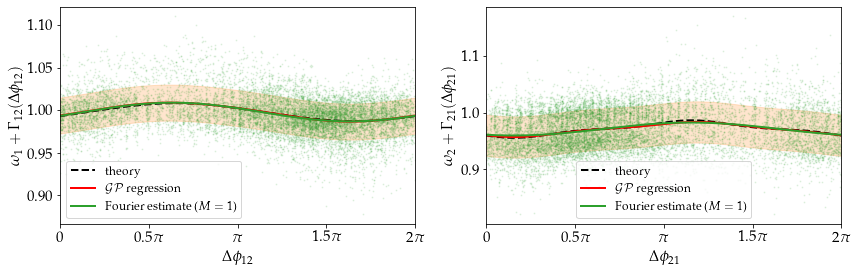

In [12]:
plt.figure(figsize=[14, 4])
plt.rcParams["font.size"] = 15
xlabels = [r"$\Delta \phi_{12}$", r"$\Delta \phi_{21}$"]
ylabels = [r"$\omega_{1}+\Gamma_{12}(\Delta \phi_{12})$", r"$\omega_{2}+\Gamma_{21}(\Delta \phi_{21})$"]
ylims = [(0.98, 1.02), (0.94, 1.00)]
locs = ["lower left", "lower center"]
for i in range(n_oscillator):
    plt.subplot(1, n_oscillator, i+1)
    plt.xlim(0,2*np.pi)
    # plt.ylim(*ylims[i])
    plt.xlabel(xlabels[i])
    plt.ylabel(ylabels[i])
    plt.xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2.0*np.pi], [r"$0$", r"$0.5\pi$", r"$\pi$", r"$1.5\pi$", r"$2\pi$"])
    plt.plot(*theories[i], c="black", ls="dashed", label="theory", lw=2) # theories
    x_gp, y_gp, var_gp, sigma_hat = gps[i]
    # plt.plot(x_gp, y_gp, color="red", label=r"$\mathcal{GP}$ regression ($\hat{\sigma}="+f"{sigma_hat:.4f}$)", lw=2)
    plt.plot(x_gp, y_gp, color="red", label=r"$\mathcal{GP}$ regression", lw=2)
    plt.plot(*otas[i][:2], c="tab:green", label=rf"Fourier estimate ($M={otas[i][-1]}$)",lw=2) # Fourier coefficient method
    plt.fill_between(x_gp, y_gp-np.sqrt(var_gp), y_gp+np.sqrt(var_gp), color="tab:orange", alpha=0.2)
    plt.scatter(*trains[i], color="tab:green", s=1, alpha=0.1)
    plt.legend(fontsize=12, loc=locs[i])
# plt.savefig(f"{folder}/{fname}.png", bbox_inches="tight", dpi=400)
plt.savefig(f"{folder}/{fname}_errorbar.pdf", bbox_inches="tight")

In [ ]:
trains[0]

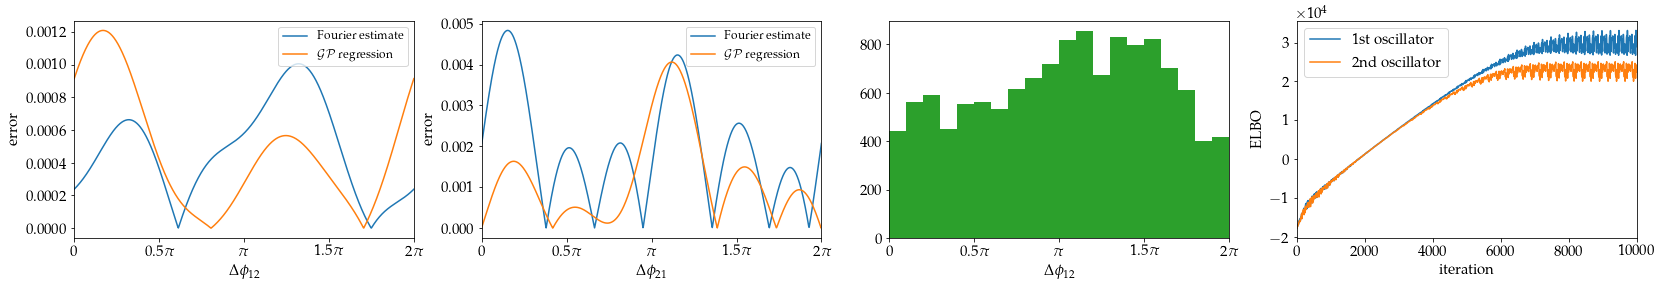

In [14]:
# errorをプロットする
plt.figure(figsize=[28, 4])
plt.rcParams["font.size"] = 15
xlabels = [r"$\Delta \phi_{12}$", r"$\Delta \phi_{21}$"]
ylabel = "error"
for i in range(n_oscillator):
    plt.subplot(1, 4, i+1)
    plt.xlim(0,2*np.pi)
    plt.xlabel(xlabels[i])
    plt.ylabel(ylabel)
    plt.xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2.0*np.pi], [r"$0$", r"$0.5\pi$", r"$\pi$", r"$1.5\pi$", r"$2\pi$"])
    x_theory, y_theory = theories[i]
    x_ota, y_ota = otas[i][:2]
    x_gp, y_gp = gps[i][:2]
    plt.plot(x_ota, np.abs(y_ota-y_theory), c="tab:blue", label=rf"Fourier estimate") # Fourier coefficient method
    plt.plot(x_gp, np.abs(y_gp-y_theory), color="tab:orange", label="$\mathcal{GP}$ regression") # GP method
    plt.legend(fontsize=12)

xlabel = r"$\Delta \phi_{12}$"
legends = ["1st oscillator", "2nd oscillator"]

# データのヒストグラム
plt.subplot(1,4,3)
plt.xlim(0,2*np.pi)
plt.xlabel(xlabel)
plt.xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2.0*np.pi], [r"$0$", r"$0.5\pi$", r"$\pi$", r"$1.5\pi$", r"$2\pi$"])
plt.hist(trains[0][0], color="tab:green", bins=20)

# ELBOの時間発展
plt.subplot(1,4,4)
plt.xlim(0,maxiter)
for i in range(2):
    plt.plot(np.arange(maxiter)[::10], logfs[i], label=legends[i])
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.legend()
plt.savefig(f"{folder}/{fname}_data.png", bbox_inches="tight", dpi=400)

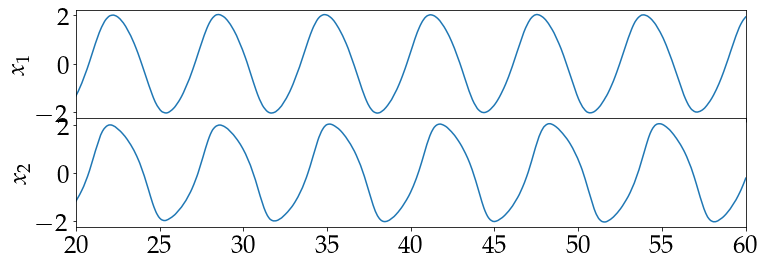

In [52]:
plt.figure(figsize=[12,4])
plt.rcParams["font.size"] = 25
plt.subplots_adjust(hspace=0.)
plt.subplot(2,1,1)
plt.xlim(20, 60)
plt.ylabel("$x_{1}$")
plt.plot(tspan, u1s[0])
plt.tick_params(labelbottom=False)
plt.subplot(2,1,2)
plt.xlim(20, 60)
plt.ylabel("$x_{2}$")
plt.plot(tspan, u2s[0])
plt.savefig("vdp_timeseries.pdf", bbox_inches="tight")

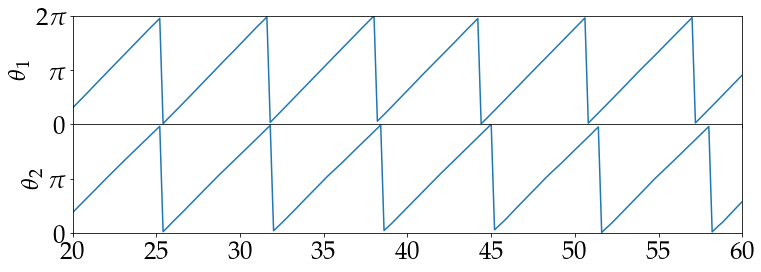

In [53]:
plt.figure(figsize=[12,4])
plt.rcParams["font.size"] = 25
plt.subplots_adjust(hspace=0.)
plt.subplot(2,1,1)
plt.xlim(20, 60)
plt.ylim(0,2*np.pi)
plt.yticks([0,np.pi, 2*np.pi], [r"$0$", r"$\pi$", r"$2\pi$"])
plt.ylabel(r"$\theta_{1}$")
plt.plot(tspan_stride, np.mod(Ps[0][:,0], 2*np.pi))
plt.tick_params(labelbottom=False)
plt.subplot(2,1,2)
plt.xlim(20, 60)
plt.ylim(0,2*np.pi)
plt.yticks([0,np.pi], [r"$0$", r"$\pi$"])
plt.ylabel(r"$\theta_{2}$")
plt.plot(tspan_stride, np.mod(Ps[0][:,1], 2*np.pi))
plt.savefig("vdp_phase_timeseries.pdf", bbox_inches="tight")